In [1]:
from __future__ import print_function
import numpy as np
import os
import sys
from scipy import ndimage
import random
import math
import pickle
import time
import dlib
from matplotlib import pylab
from six.moves import range
import matplotlib.pyplot as plt
from skimage import io

try:
    import Image
except ImportError:
    from PIL import Image

plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (14, 7) 

In [2]:
#Константы
landmark_n = 68
nose_index = 27
chin_index = 8  
bagging_overlap = 0.4 #Коэффициент перекрытия. Когда мы делим тренировочные данные между деревьями, 
# некоторая часть данных может совпадать.

features_n = [500, 500, 500, 300, 300, 300, 200, 200, 200, 100]
radiuses = [0.3, 0.2, 0.15, 0.12, 0.10, 0.10, 0.08, 0.06, 0.06, 0.05]

In [7]:
def project_to_box(shape, box):
    shape = shape.astype(np.float64)
    x0 = (box.left() + box.right())/2.
    y0 = (box.bottom() + box.top())/2.
    h = (box.bottom() - box.top())/2.
    w = (box.right() - box.left())/2.
    
    try:
        shape[:,0] -= x0
        shape[:,1] -= y0
    except IndexError:
        print(shape)
    
    shape[:,0] /= w
    shape[:,1] /= h
        
    return shape

def reproject(shape, box):
    shape = shape.astype(np.float64)
    x0 = (box.left() + box.right())/2.
    y0 = (box.bottom() + box.top())/2.
    h = (box.bottom() - box.top())/2.
    w = (box.right() - box.left())/2.
    
    shape[:,0] *= w
    shape[:,1] *= h
    
    shape[:,0] += x0
    shape[:,1] += y0
        
    return shape

def transform(control_shape, shape): #Как нужно изменить среднюю форму, чтобы получить текущую
    nose_index = 27
    chin_index = 8  
    
    nose = control_shape[nose_index]
    chin = control_shape[chin_index]
    
    vector = chin-nose
    length = math.sqrt(vector[0]**2 + vector[1]**2)
    angle = 0
    
    if vector[1]>0:
        angle = math.acos(vector[0]/length) + math.pi/2
    angle = math.acos(-vector[0]/length) - math.pi/2

    cos = math.cos(angle)
    sin = math.sin(angle)
    
    rotation_matrix = np.array([[cos, -sin], [sin, cos]])
    
    scale = length / mean_length
    
    for point in range(shape.shape[0]):
        shape[point] = np.dot(shape[point], rotation_matrix)
        shape[point] *= scale
        
    return shape

def retransform(control_shape, shape): #Как нужно изменить текущую форму, чтобы получить среднюю
    nose_index = 27
    chin_index = 8  
    
    nose = control_shape[nose_index]
    chin = control_shape[chin_index]
    
    vector = chin-nose
    length = math.sqrt(vector[0]**2 + vector[1]**2)
    angle = 0
    
    if vector[1]>0:
        angle = math.acos(vector[0]/length) - math.pi/2
    angle = math.acos(-vector[0]/length) + math.pi/2

    cos = math.cos(angle)
    sin = math.sin(angle)
    
    rotation_matrix = np.array([[cos, sin], [-sin, cos]])
    
    scale = mean_length / length
    
    for point in shape:
        point = np.dot(point, rotation_matrix)
        point *= scale
        
    return shape

class feature:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        
    def print_(self):
        print(self.x1, self.y1, self.x2, self.y2)
        
def generate_feature(radius):
    x1 = 1
    y1 = 1
    while(x1*x1 + y1*y1 > 1):
        x1 = random.uniform(-1, 1) 
        y1 = random.uniform(-1, 1) 
        
    x2 = 1
    y2 = 1
    while(x2*x2 + y2*y2 > 1):
        x2 = random.uniform(-1, 1) 
        y2 = random.uniform(-1, 1)
        
    return feature(x1*radius, y1*radius, x2*radius, y2*radius)

def find_variance(vector):
    if vector.shape[0]==0:
        return 0
    E1 = np.mean(vector*vector)
    E2 = np.mean(vector)
    return E1 - E2*E2

class Box: #Я внезапно заметил, что Rectangle от Dlib работает слишком медленно, 
    # поэтому влёгкую опишем свой класс
    def __init__(self, top, bottom, left, right):
        self._top = top
        self._bottom = bottom
        self._left = left
        self._right = right
    def top(self):
        return self._top
    def bottom(self):
        return self._bottom
    def left(self):
        return self._left
    def right(self):
        return self._right

In [8]:
class Tree:
    def __init__ (self, stage, landmark_id, depth):
        self.landmark_id = landmark_id #номер точки, к которой относится дерево
        self.depth = depth #Глубина дерева
        self.nodes_num = 2**depth
        self.stage = stage #Стадия, к которой относится дерево
        self.thresholds = np.zeros(self.nodes_num) #
        self.features = [feature(0, 0, 0, 0)] * self.nodes_num
        
    def train(self, images, correct_shapes, start_shapes, delta_shapes, boxes, node_id=1):
        if len(images) == 0:
            return
        if 2*node_id >= self.nodes_num:
            return
        
        print('start training node {} with {} images'.format(node_id, len(images)))
        min_variance = 1e9+55
        start_time = time.time()        
        left_images      = list() #Картинки, которые пойдут влево
        right_images     = list() #Картинки, которые пойдут вправо
        left_correct     = list() #Правильные точки, которые пойдут влево
        right_correct    = list() #Правильные точки, которые пойдут вправо
        left_start       = list() #Начальные точки, которые пойдут влево
        right_start      = list() #Начальные точки, которые пойдут вправо
        left_delta       = list() #Сдвиги, которые пойдут влево
        right_delta      = list() #Сдвиги, которые пойдут вправо
        left_boxes       = list() #Прямоугольники, которые пойдут влево
        right_boxes      = list() #Прямоугольники, которые пойдут вправо
        best_differences = list() #Разницы в яркости для каждой картинки у того признака, который мы посчитаем лучшим
        differences      = [0] * len(images) #Просто массив с разницами, который будем перезаписывать на каждом шаге цикла
        normed_start_shapes = list()
        for i in range(len(images)):
            normed_start_shapes.append(project_to_box(start_shapes[i]*1, boxes[i]))
    
        for feat in range(features_n[self.stage]):
            current_feature = generate_feature(radiuses[self.stage]) #Генерируем новую пару пикселей
            for i in range(len(images)):
                #Короче, сейчас адский ад начнётся, отвечаю
                # Этот код переписан практически без numpy, выглядит не так красиво и читаемо,
                # зато даёт очень значительный прирост в скорости
                
                #Копируем координаты, чтобы изменять их
                x1 = current_feature.x1 * 1
                y1 = current_feature.y1 * 1
                x2 = current_feature.x2 * 1
                y2 = current_feature.y2 * 1
                
                #Вычисляем вектор между носом и подбородком и его длину
                vector_x = normed_start_shapes[i][nose_index][0]-normed_start_shapes[i][chin_index][0]
                vector_y = normed_start_shapes[i][nose_index][1]-normed_start_shapes[i][chin_index][1]
                length = math.sqrt(vector_x * vector_x + vector_y * vector_y)
                scale = length / mean_length #Во сколько увеличена маска по сравнению со средней 

                #Масштабируем наши координаты
                x1 *= scale
                x2 *= scale
                y1 *= scale
                y2 *= scale
                
                #Вычисляем угол поворота маски. Формулы изменены, 
                # поскольку мы считаем угол от вертикали
                sin = -vector_x/length
                cos = -vector_y/length

                #Поворачиваем пару на тот же угол, на который повёрнута маска
                x1_t = x1
                y1_t = y1
                x1 = x1_t*cos + y1_t * sin
                y1 = y1_t*cos - x1_t * sin
                x2_t = x2
                y2_t = y2
                x2 = x2_t*cos + y2_t * sin
                y2 = y2_t*cos - x2_t * sin

                #Поскольку координаты маски даны разделёнными на стороны прямоугольника,
                # умножаем обратно
                h = (boxes[i].bottom() - boxes[i].top())/2.
                w = (boxes[i].right() - boxes[i].left())/2.
                x1 *= w
                x2 *= w
                y1 *= h
                y2 *= h

                # И прибавляем координаты ключевой точки, вокруг которой мы работаем
                x1 += start_shapes[i][self.landmark_id][0]
                x2 += start_shapes[i][self.landmark_id][0]
                y1 += start_shapes[i][self.landmark_id][1]
                y2 += start_shapes[i][self.landmark_id][1]
                
                #Находим разницу между этими пикселями на изображении
                differences[i] = (image_set[images[i]][int(y1)][int(x1)] - 
                                    image_set[images[i]][int(y2)][int(x2)])
            
            #Распределять delta_shapes по спискам занимает слишком много времени, поэтому 
            # дисперсию будем считать на ходу:
            
            left_x = 0
            left_y = 0
            square_left_x = 0
            square_left_y = 0
            left_n = 0
            
            right_x = 0
            right_y = 0
            square_right_x = 0
            square_right_y = 0
            right_n = 0
            
            control_difference = differences[random.randint(0, len(images)-1)] #Выбираем рандомную разницу, относительно
            # которой будем делить примеры по сыновьям 
            
            for i in range(len(images)):
                x = delta_shapes[i][0]
                y = delta_shapes[i][1]
                if differences[i] < control_difference:
                    left_x += x
                    left_y += y
                    square_left_x += x*x
                    square_left_y += y*y
                    left_n += 1
                else:
                    right_x += x
                    right_y += y
                    square_right_x += x*x
                    square_right_y += y*y
                    right_n += 1
                    
            left_n = max(left_n, 1)
            right_n = max(right_n, 1) #Костыль, чтобы исключить деление на ноль
            
            current_variance = (((square_left_x/left_n - (left_x/left_n)*(left_x/left_n)) + 
                                (square_left_y/left_n - (left_y/left_n)*(left_y/left_n))) * left_n + 
                                ((square_right_x/right_n - (right_x/right_n)*(right_x/right_n)) + 
                                (square_right_y/right_n - (right_y/right_n)*(right_y/right_n))) * right_n)
            
            # Да-да, всё это время мы только лишь считали variance. Ничего, сейчас экшн начнётся
            
            if min_variance > current_variance: #Если с таким признаком мы получили лучшую variance, обновляем
                min_variance = current_variance
                self.features[node_id] = current_feature
                self.thresholds[node_id] = control_difference
                best_differences = differences
        
        # Всё, лучший признак для вершины нашли. Теперь делим данные по сыновьям и идём дальше
        for i in range(len(images)):
            if best_differences[i] < self.thresholds[node_id]:
                left_images.append(images[i]) # (len(images) x 1)
                left_delta.append(delta_shapes[i]) # (len(images) x 2)
                left_boxes.append(boxes[i]) # (len(images) x 4)
                left_correct.append(correct_shapes[i]) # (len(images) x 68 x 2)
                left_start.append(start_shapes[i])# (len(images) x 68 x 2)
            else:
                right_images.append(images[i])
                right_delta.append(delta_shapes[i])
                right_boxes.append(boxes[i])
                right_correct.append(correct_shapes[i])
                right_start.append(start_shapes[i])  
                
        left_delta = np.array(left_delta)
        right_delta = np.array(right_delta)
        
        print('trained node {} in {}'.format(node_id, time.time() - start_time))
        if(2*node_id+1 < self.nodes_num): #Рекурсивно обучаем сыновей
            self.train(left_images, left_correct, left_start, left_delta, left_boxes, node_id * 2)
            self.train(right_images, right_correct, right_start, right_delta, right_boxes, node_id * 2 + 1)

In [2]:
a = [0]
print(a)
a *= 10
print(a)

[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
class RandomForest:
    
    def __init__(self, stage, trees_n, tree_depth):
        self.forest = list() # (68 x trees_n = 12)
        for landmark_id in range(landmark_n):
            self.forest.append([])
            for tree_id in range(trees_n):
                self.forest[landmark_id].append(Tree(stage, landmark_id, tree_depth))
        self.trees_n = trees_n 
        self.tree_depth = tree_depth 
        
    def train(self, images, сorrect_shapes, start_shapes, delta_shapes, boxes):
        step = int(len(images)/((1-bagging_overlap)*self.trees_n))
        
        for landmark_id in range(landmark_n):
            for tree_id in range(self.trees_n):
                cur_images         = list()
                cur_correct_shapes = list()
                cur_start_shapes   = list()
                cur_delta_shapes   = list()
                cur_boxes          = list()
                
                start = int(max(0, tree_id*step - tree_id*step*bagging_overlap))
                finish = min(start + step + 1, len(images))
                
                for file in range (start, finish):
                    cur_images.append(images[file])
                    cur_correct_shapes.append(сorrect_shapes[file])
                    cur_start_shapes.append(start_shapes[file])
                    cur_delta_shapes.append(delta_shapes[file][landmark_id])
                    cur_boxes.append(boxes[file])
                    
                cur_delta_shapes = np.array(cur_delta_shapes)
                print('Landmark: {} Tree: {}'.format(landmark_id, tree_id))
                self.forest[landmark_id][tree_id].train(cur_images, cur_correct_shapes, cur_start_shapes, cur_delta_shapes, cur_boxes)
                
    def getLBF(self, image, current_shape, box):#Функция, которая выдаёт вектор из нулей и единичек после того,
        # как лес уже обучен
        result = list() # Мерж из векторов, полученных от каждого дерева
        for landmark_id in range(landmark_n):
            for tree_id in range(self.trees_n):
                vector = [0] #Вектор из нулей и единичек, который получим на выходе
                vector *= 2**(self.forest[landmark_id][tree_id].depth - 1)
                # Нерекурсивный проход по дереву:
                node_id = 1
                while node_id < self.forest[landmark_id][tree_id].nodes_num/2:
                    
                    #Преобразовываем пару пикселей. Просто скопировал код сверху. Можно и в отдельную функцию вынести...
                    #
                    # А можно и не выносить
                    
                    current_feature = self.forest[landmark_id][tree_id].features[node_id]
                    #Копируем координаты, чтобы изменять их
                    x1 = current_feature.x1 * 1
                    y1 = current_feature.y1 * 1
                    x2 = current_feature.x2 * 1
                    y2 = current_feature.y2 * 1

                    normed_shape = project_to_box(current_shape*1, box)
                    #Вычисляем вектор между носом и подбородком и его длину
                    vector_x = normed_shape[nose_index][0]-normed_shape[chin_index][0]
                    vector_y = normed_shape[nose_index][1]-normed_shape[chin_index][1]
                    length = math.sqrt(vector_x * vector_x + vector_y * vector_y)
                    scale = length / mean_length #Во сколько увеличена маска по сравнению со средней 

                    #Масштабируем наши координаты
                    x1 *= scale
                    x2 *= scale
                    y1 *= scale
                    y2 *= scale

                    #Вычисляем угол поворота маски. Формулы изменены, 
                    # поскольку мы считаем угол от вертикали
                    sin = -vector_x/length
                    cos = -vector_y/length

                    #Поворачиваем пару на тот же угол, на который повёрнута маска
                    x1_t = x1
                    y1_t = y1
                    x1 = x1_t*cos + y1_t * sin
                    y1 = y1_t*cos - x1_t * sin
                    x2_t = x2
                    y2_t = y2
                    x2 = x2_t*cos + y2_t * sin
                    y2 = y2_t*cos - x2_t * sin

                    #Поскольку координаты маски даны разделёнными на стороны прямоугольника,
                    # умножаем обратно
                    h = (box.bottom() - box.top())/2.
                    w = (box.right() - box.left())/2.
                    x1 *= w
                    x2 *= w
                    y1 *= h
                    y2 *= h

                    # И прибавляем координаты ключевой точки, вокруг которой мы работаем
                    x1 += current_shape[1][0]
                    x2 += current_shape[1][0]
                    y1 += current_shape[1][1]
                    y2 += current_shape[1][1]

                    #Находим разницу между этими пикселями на изображении
                    difference = (image[int(y1)][int(x1)] - 
                                  image[int(y2)][int(x2)])
    
                    #Переходим в одного из сыновей
                    node_id *= 2
                    if difference >= self.forest[landmark_id][tree_id].thresholds[node_id]:
                        node_id += 1
                        
                    #Если дошли до нижнего слоя, ставим единичку в вектор
                    if 2*node_id >= self.forest[landmark_id][tree_id].nodes_num:
                        #print(node_id)
                        vector_index = node_id - self.forest[landmark_id][tree_id].nodes_num//2
                        #print(vector_index)
                        
                        vector[vector_index] = 1
                        #print(vector)
                        result.extend(vector)
        return result

In [10]:
def get_delta_shapes(start_shapes, correct_shapes, boxes):
    delta_shapes = list()
    for i in range(len(start_shapes)):
        temp = project_to_box(correct_shapes[i], boxes[i]) - project_to_box(start_shapes[i], boxes[i])
        temp = retransform(project_to_box(correct_shapes[i], boxes[i]), temp)
        delta_shapes.append(temp)
    return np.array(delta_shapes)

In [11]:
pickle_file = 'Face alignment(test).pickle'

with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
    train_images = data['images']
    train_boxes = data['boxes']
    train_shapes = data['shapes']
    train_start_shapes = data['start shapes']
    image_set = data['image_set']
    del data
    f.close()

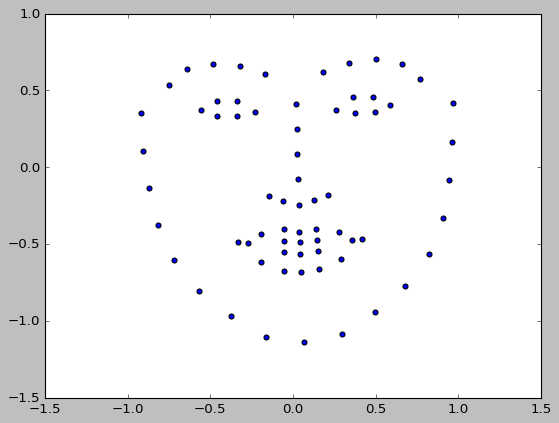

1.5482825451490132


In [14]:
# Получаем среднюю маску

mean_shape = np.zeros((landmark_n, 2))

for i in range(len(train_shapes)):
    mean_shape += project_to_box(train_shapes[i], train_boxes[i])
    
mean_shape /= len(train_shapes)

plt.style.use('classic') 

for i in range(landmark_n):
    x = mean_shape[i][0]
    y = -mean_shape[i][1]
    pylab.scatter(x, y)
    pylab.annotate('', xy=(x, y), ha='right', va='bottom')

pylab.show()

v_x = mean_shape[nose_index][0]-mean_shape[chin_index][0]
v_y = mean_shape[nose_index][1]-mean_shape[chin_index][1]
mean_length = math.sqrt(v_x * v_x + v_y * v_y)

print(mean_length)

In [15]:
rf1 = RandomForest(1, 5, 5)

In [16]:
delta_shapes = get_delta_shapes(train_start_shapes, train_shapes, train_boxes)
print(delta_shapes.shape)

(5340, 68, 2)


In [ ]:
rf1.train(train_images, train_shapes, train_start_shapes, delta_shapes, train_boxes)